<a href="https://colab.research.google.com/github/timothy-voiuhy/CrackDetection/blob/main/CrackClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics
!pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.6 MB/s eta 0:00:00


In [1]:
from pathlib import Path
import torch
from tqdm.auto import tqdm
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import v2
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torchcam.methods import GradCAM, LayerCAM
from torchcam.utils import overlay_mask
import sys

In [13]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR_PATH = "/content/drive/MyDrive/DATA/cracksDatasets/cracks/"
    BEST_MODEL_PATH = "/content/drive/MyDrive/Models/cracks_bmV5.pth"
    BATCH_SIZE = 256
except:
    DATA_DIR_PATH = "C:\\Users\\Student\\Downloads\\cracks_dataset"
    BATCH_SIZE = 256

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# uzip the cracks_dataset.zip file
# with zipfile.ZipFile(ZIP_DIR, 'r') as zip_ref:
#     zip_ref.extractall(DATA_DIR_PATH)
# !unzip /content/drive/MyDrive/cracks.zip -d /content/drive/MyDrive/DATA/cracksDatasets/

In [20]:
DATA_DIR_PATH = "/content/cracks/"

In [10]:
!ls cracks

test  train  val


In [26]:
class CrackDetectionModel(nn.Module):
    def __init__(self):
        super(CrackDetectionModel, self).__init__()
        self.conv1 = self.buildConvBlock(3, 32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = self.buildConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = self.buildConvBlock(64, 128)
        self.flatten = nn.Flatten()  # Flatten the ouput of the pooling layer ready for the feed forwad networks
        self.fc1 = nn.Linear(100352, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.sigmoid = nn.Sigmoid()

    def buildConvBlock(self, in_features, out_features):
        return nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(out_features),
            nn.ReLU(inplace = True),
        )

    def forward(self, x):
        x = self.pool1(self.conv1(x)) # apply pooling to the output of the first convolution
        x = self.pool2(self.conv2(x))
        x = self.conv3(x)
        x = self.flatten(x)  # Use nn.Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [15]:
# class customDataset(Dataset):
#     def __init__(self, root, data, labels, classes = None, transform=None):
#         self.root = root
#         self.transform = transform
#         self.data = data
#         self.labels = labels
#         self.classes = classes

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         image = self.data[index]
#         label = self.labels[index]
#         if type(image) == str:
#             image = Image.open(image)
#             if self.transform:
#                 image = self.transform(image)
#         return image, label

# def createCustomDataLoader(data, labels, batch_size=64, shuffle=True):
#     transform = transforms.Compose(
#         [transforms.Resize((128, 128)),
#         transforms.ToTensor()]
#     )
#     dataset = customDataset(root=DATA_DIR_PATH, data=data, labels=labels, transform=transform)
#     dataLoader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
#     return dataLoader

def createDataLoader(root, batch_size, shuffle = True, test = False):
    dataset = createDataset(root, test = test)
    dataLoader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    return dataLoader

def createDataset(root, test = False):
    if test is False:
        transform = v2.Compose([
            v2.Resize((128, 128)),
            v2.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.8, 1.2)),
            v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.2),
            v2.ToTensor(),
            v2.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
        ])
    else:
        transform = v2.Compose([
            v2.Resize((128, 128)),
            v2.ToTensor(),
            v2.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
        ])
    dataset = ImageFolder(root, transform=transform)
    return dataset

def visualizeImages(num_images=15, root = None):
    data_loader = createDataLoader(root, BATCH_SIZE)
    data_loader_iter = iter(data_loader)
    class_names = data_loader.dataset.classes
    images, labels = next(data_loader_iter)
    fig = plt.figure(figsize = (10, 10))
    if num_images % 5 == 0:
        n_rows = num_images // 5
    else:
        n_rows = num_images // 5 + 1
    for i in range(num_images):
        plt.subplot(n_rows, 5, i+1)
        plt.imshow(images[i].permute(1, 2, 0))
        # plt.title(class_names[i])
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

def getData(root:str):
    data = []
    labels = []
    classnames = []
    for root, dirs, files in os.walk(root):
        for file in files:
            file_path = os.path.join(root, file)
            class_name = file_path.split('/')[-2]
            label = class_name
            data.append(file_path)
            labels.append(label)
            classnames.append(class_name)
    return data, labels, classnames

def splitData(data, labels, test_size=0.2, val_size=0.2):
    # split the data into training, validation and test data
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=test_size, random_state=42)
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=val_size, random_state=42)
    return train_data, val_data, test_data, train_labels, val_labels, test_labels

def trainModel(model:CrackDetectionModel, train_loader:DataLoader, val_loader:DataLoader, optimizer, loss_fn, epochs = 10, device = None):
    torch.manual_seed(42)
    best_val_loss = float('inf')
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch} .........")
        train_loss = 0
        train_accuracy = 0
        work_image_count  = 0
        for batch_index, (images, labels) in  enumerate(train_loader):
            model.train()
            if device:
                images = images.to(device)
                labels = labels.to(device)
            output = model(images)
            labels = labels.float().view(-1, 1)

            loss = loss_fn(output, labels)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            preds = (output > 0.5).float()
            accuracy = accuracy_score(labels.cpu(), preds.cpu())
            train_accuracy += accuracy
            if (batch_index+1) % 10 == 0:
                print(f"Worked on : {batch_index + 1} of {len(train_loader)} batches")
            work_image_count += len(images)
            if work_image_count % 1000 == 0:
                print(f"Worked on : {work_image_count} images / {len(train_loader)*BATCH_SIZE} images")

        # Validate the model per epoch count
        validation_loss, validation_accuracy = validate(model, val_loader, loss_fn, device=device)
        average_loss = train_loss / len(train_loader)
        average_accuracy = train_accuracy /len(train_loader)
        print(f"Epoch: {epoch} Train Loss: {average_loss}, Train Accuracy: {average_accuracy}, Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}")
        if validation_loss < best_val_loss:
            print("Saving model .............")
            best_val_loss = validation_loss
            torch.save(model.state_dict(), BEST_MODEL_PATH)

def validate(model, data_loader, loss_fn, device = None):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    with torch.inference_mode():
        for images, labels in data_loader:
            if device is not None:
                images = images.to(device)
                labels = labels.to(device)
            output = model(images)
            labels = labels.float().view(-1, 1)
            loss = loss_fn(output, labels)
            total_loss += loss.item()

            preds = (output > 0.5).float()
            accuracy = accuracy_score(labels.cpu(), preds.cpu())
            total_accuracy += accuracy

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = total_accuracy / len(data_loader)
    return avg_loss, avg_accuracy

def splitFiles(root, label1_name, label2_name, test_split = 0.2, val_split = 0.2):
    label1_files = []
    label2_files = []
    train_dir = os.path.join(root, 'train')
    train_label1_dir = os.path.join(train_dir, label1_name)
    train_label2_dir = os.path.join(train_dir, label2_name)
    test_dir = os.path.join(root,"test")
    test_label1_dir = os.path.join(test_dir, label1_name)
    test_label2_dir = os.path.join(test_dir, label2_name)
    val_dir = os.path.join(root, 'val')
    val_label1_dir = os.path.join(val_dir, label1_name)
    val_label2_dir = os.path.join(val_dir, label2_name)
    __dirs = [train_dir, train_label1_dir, train_label2_dir, test_dir, test_label1_dir, test_label2_dir, val_dir, val_label1_dir, val_label2_dir]

    for __dir in __dirs:
        if not Path(__dir).exists():
            os.mkdir(__dir)
    label1_dir = os.path.join(root, label1_name)
    label2_dir = os.path.join(root, label2_name)
    if  Path(label1_dir).exists(): # if one of the label directories exists then the function has not been run.
        dirs = [label1_dir, label2_dir]
        for __dir in dirs:
            for root, dirs, files in os.walk(__dir):
                for file in files:
                    file_path = os.path.join(root, file)
                    if __dir == label1_dir:
                        label1_files.append(file_path)
                    else:
                        label2_files.append(file_path)

        print(f"n_label1_files: {len(label1_files)}")
        print(f"n_label2_files: {len(label2_files)}")
        # split the label files into traing, testing, validation files and move them to the respecitve folders
        train_label1_files, test_label1_files = train_test_split(label1_files, test_size=test_split)
        train_label1_files, val_label1_files = train_test_split(train_label1_files, test_size=val_split)
        train_label2_files, test_label2_files = train_test_split(label2_files, test_size=test_split)
        train_label2_files, val_label2_files = train_test_split(train_label2_files, test_size=val_split)

        print(f"num_train_label1files: {len(train_label1_files)}")
        print(f"num_test_label1files: {len(test_label1_files)}")
        print(f"num_val_label1files: {len(val_label1_files)}")
        # move the files to the respective folders
        delimeter = ""
        if sys.platform == "win32":
            delimeter = "\\"
        elif sys.platform == "linux":
            delimeter = "/"
        for file in train_label1_files:
            shutil.move(file, os.path.join(train_dir, label1_name, file.split(delimeter)[-1]))
        for file in train_label2_files:
            shutil.move(file, os.path.join(train_dir, label2_name, file.split(delimeter)[-1]))
        for file in test_label1_files:
            shutil.move(file, os.path.join(test_dir, label1_name, file.split(delimeter)[-1]))
        for file in test_label2_files:
            shutil.move(file, os.path.join(test_dir, label2_name, file.split(delimeter)[-1]))
        for file in val_label1_files:
            shutil.move(file, os.path.join(val_dir, label1_name, file.split(delimeter)[-1]))
        for file in val_label2_files:
            shutil.move(file, os.path.join(val_dir, label2_name, file.split(delimeter)[-1]))

        os.rmdir(label1_dir)
        os.rmdir(label2_dir)
        return train_dir, test_dir, val_dir
    else:
        return train_dir, test_dir, val_dir


In [16]:
def testModel(model, data_loader, loss_fn, device = None):
  model.eval()
  total_loss = 0
  total_accuracy = 0
  with torch.inference_mode():
    for images, labels in data_loader:
      if device is not None:
        images = images.to(device)
        labels = labels.to(device)
      output = model(images)
      labels = labels.float().view(-1, 1)
      loss = loss_fn(output, labels)
      total_loss += loss.item() # accumulatively calculate the loss
      preds = (output > 0.5).float()
      accuracy = accuracy_score(labels.cpu(), preds.cpu())
      total_accuracy += accuracy # accumulatively calculate the accuracy

  avg_loss = total_loss / len(data_loader)
  avg_accuracy = total_accuracy / len(data_loader)
  return avg_loss, avg_accuracy

In [ ]:
# splitFiles(DATA_DIR_PATH, "Negative", "Positive")

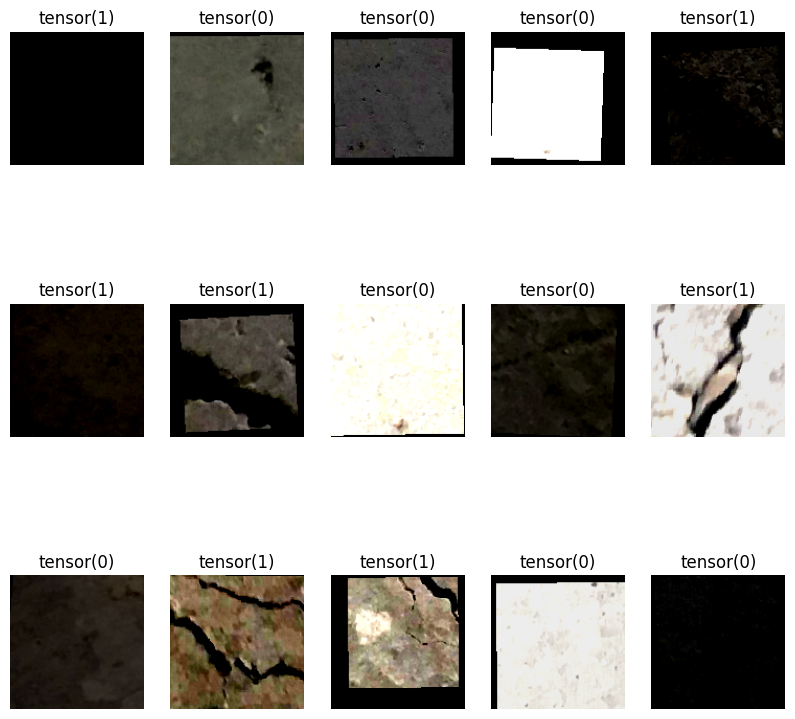

In [21]:
visualizeImages(root=DATA_DIR_PATH+"train")

In [22]:
train_dir = DATA_DIR_PATH+"train"
test_dir = DATA_DIR_PATH+"test"
val_dir = DATA_DIR_PATH+"val"

# train_dir, test_dir, val_dir = splitFiles(DATA_DIR_PATH, "Negative", "Positive")
train_dataloader = createDataLoader(train_dir, batch_size=BATCH_SIZE)
test_dataloader = createDataLoader(test_dir, batch_size=BATCH_SIZE)
val_dataloader = createDataLoader(val_dir, batch_size=BATCH_SIZE)

In [ ]:
del test_dataloader

In [ ]:
test_dataloader = createDataLoader(test_dir, batch_size = 32, test=True)

In [27]:
# device agnostic code
if torch.cuda.is_available():
    print("GPU Available")
    device = torch.device("cuda")
    torch.backends.cuda.matmul.allow_tf32 = True
else:
    device = torch.device("cpu")


GPU Available


In [28]:
model = CrackDetectionModel()
model.to(device)

CrackDetectionModel(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

# train the model
trainModel(model, train_dataloader, val_dataloader, optimizer, loss_fn, epochs= 20, device= device)

# test the model using the test DataLoader
# test_loss, test_accuracy = validate(model, test_dataloader, loss_fn)
# print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 .........
Worked on : 10 of 100 batches
Worked on : 20 of 100 batches
Worked on : 30 of 100 batches
Worked on : 40 of 100 batches
Worked on : 50 of 100 batches
Worked on : 60 of 100 batches
Worked on : 70 of 100 batches
Worked on : 80 of 100 batches
Worked on : 90 of 100 batches
Worked on : 100 of 100 batches
Epoch: 0 Train Loss: 6.136319068074227, Train Accuracy: 0.900078125, Validation Loss: 2.705837059020996, Validation Accuracy: 0.9425
Saving model .............
Epoch: 1 .........
Worked on : 10 of 100 batches
Worked on : 20 of 100 batches
Worked on : 30 of 100 batches
Worked on : 40 of 100 batches
Worked on : 50 of 100 batches
Worked on : 60 of 100 batches
Worked on : 70 of 100 batches
Worked on : 80 of 100 batches
Worked on : 90 of 100 batches
Worked on : 100 of 100 batches
Epoch: 1 Train Loss: 1.0515341546013952, Train Accuracy: 0.9548046875, Validation Loss: 0.11613314792513847, Validation Accuracy: 0.97328125
Saving model .............
Epoch: 2 .........
Worked on : 1

In [ ]:
test_loss, test_accuracy = testModel(model, test_dataloader, loss_fn, device)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

In [ ]:
def predict_single_image(image_path, model, device):
    """Predicts the class of a single crack image.

    Args:
        image_path: Path to the image file.
        model: The trained PyTorch model.
        device: The device to run the prediction on (CPU or GPU).

    Returns:
        The predicted class (0 for no crack, 1 for crack).
    """

    # Load and preprocess the image
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the device
    if device:
        image = image.to(device)

    # Make the prediction
    with torch.no_grad():  # Disable gradient calculation
        output = model(image)

    # Get the predicted class
    predicted_class = (output > 0.5).float().item()

    return predicted_class, output

In [ ]:
# BEST_MODEL_PATH = "/media/kali/system2/home/program/AI_ML/AI_ML_DEV_PY/crackDetection/Models/cracks_bm.pth"
savedModel = CrackDetectionModel()
savedModel.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
savedModel.eval()
if device:
  savedModel.to(device)

predicted class : 1.0 model_pred: 1.0
predicted class : 1.0 model_pred: 0.9999499320983887
predicted class : 1.0 model_pred: 0.9999380111694336
predicted class : 1.0 model_pred: 0.9992756247520447
predicted class : 0.0 model_pred: 0.0004814653948415071


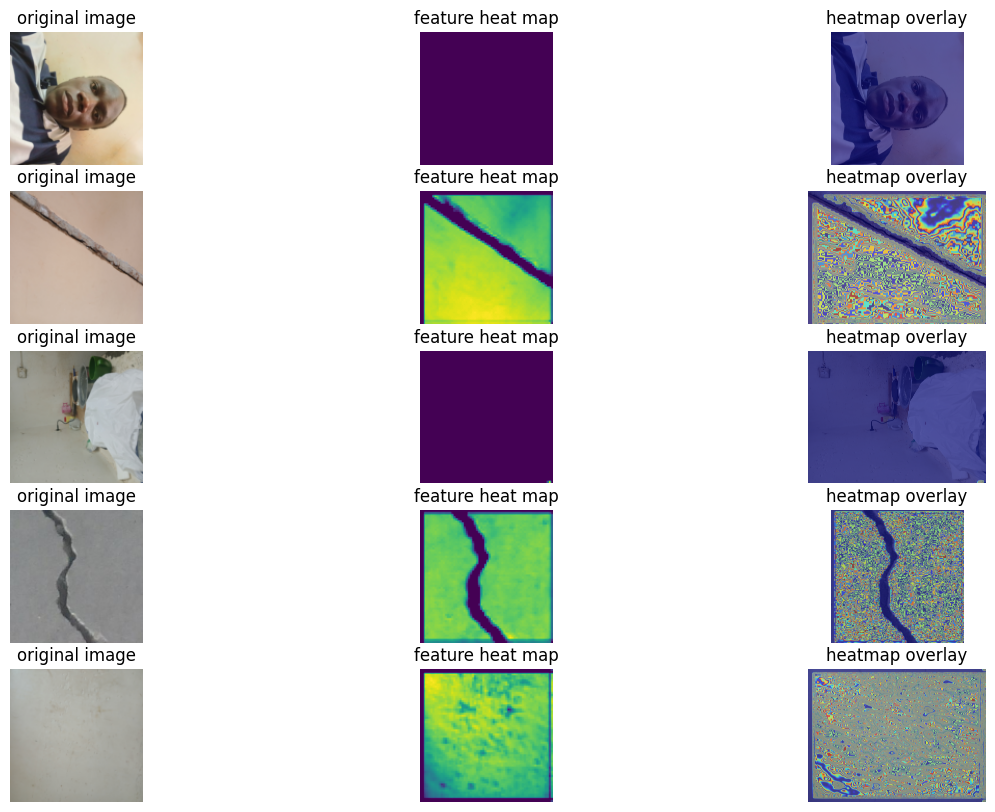

In [ ]:
images, labels = next(iter(test_dataloader))

n_rows = 10

images = []
cams  =[]
plt.figure(figsize = (15,10))
tr = v2.ToPILImage()
for idx, image in enumerate(images):
    if idx == n_rows-1:
        break
    image = image.unsqueeze(0)  # Add batch dimension

    image_ = image.squeeze(0).permute((1,2,0))
    plt.subplot(n_rows, 3, idx+1)
    plt.title("original image")
    plt.imshow(image_)
    plt.axis("off")
    # Move the image to the device
    if device:
        image = image.to(device)

    # now lets use gradcam to see what the model is doing
    cam_extractor = GradCAM(model, target_layer = "conv2")
    # Make the prediction
    output = model(image)
    predicted_class = (output > 0.5).float().item()
    print(f"predicted class : {predicted_class} model_pred: {output.item()}")
    predicted_class_index = output.argmax().item() # choose the class index for which to visualize
    cams = cam_extractor(predicted_class_index, output)
    fused_cam = cam_extractor.fuse_cams(cams)
    overlayed_img = overlay_mask(tr(img), tr(fused_cam), alpha = 0.4)
    fused_cam = fused_cam.permute((1,2,0))

    plt.subplot(n_rows, 3, idx+2)
    plt.title("feature heat map")
    plt.imshow(fused_cam)
    plt.axis("off")

    plt.subplot(n_rows, 3, idx+3)
    plt.imshow(overlayed_img)
    plt.axis("off")
    plt.title("heatmap overlay")

    idx += 3
plt.show()

In [ ]:
# Results explanation